In [1]:
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

Make word vectors:

In [2]:
from itertools import product
from make import make

bitlevel = 0, 1
size = 100, 200, 400, 600, 800, 1000
num_iter = 1, 10, 25, 50

targets = [
    '{}b_{}d_vectors_e{}'.format(*params)
    for params in product(bitlevel, size, num_iter)
]
make(targets, directory='vectors')

2019-04-15 03:03:49,844 : Making 48 targets in directory vectors/
2019-04-15 10:51:56,946 : Done making targets


Compute accuracy:

In [3]:
make(('compute_accuracy', 'compute_accuracy_bitwise'), directory='Word2Bits')
make(targets, directory='analogy', num_processes='all')
make(targets, directory='analogy_bitwise', num_processes='all')

2019-04-15 19:59:58,468 : Making 2 targets in directory Word2Bits/
2019-04-15 19:59:59,225 : Done making targets
2019-04-15 19:59:59,226 : Making 48 targets using 32 threads in directory analogy/
2019-04-15 20:24:04,755 : Done making targets
2019-04-15 20:24:04,757 : Making 48 targets using 32 threads in directory analogy_bitwise/
2019-04-15 20:25:36,326 : Done making targets


Plot accuracy and loss:

In [4]:
import re

def get_accuracy(params, bitwise=False):
    filename = 'analogy{}/{}b_{}d_vectors_e{}'.format('_bitwise' if bitwise else '', *params)
    with open(filename, 'rt') as f:
        line = f.readlines()[-3]
    match = re.match(r'^Total accuracy: (?P<accuracy>[0-9.]*) %.*$', line)
    assert match, 'Failed to find accuracy in {}'.format(filename)
    accuracy = float(match.groups('accuracy')[0])
    return accuracy

def get_loss(params):
    filename = 'vectors/{}b_{}d_vectors_e{}.log'.format(*params)
    with open(filename, 'rt') as f:
        line = f.readlines()[-1]
    match = re.match(r'^.*Epoch Loss: -(?P<loss>[0-9.]*)$', line)
    assert match, 'Failed to find loss in {}'.format(filename)
    loss = float(match.groups('loss')[0])
    return loss

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 20

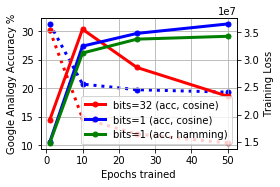

In [6]:
fig, ax = plt.subplots()
fig.set_figheight(2.7)
fig.set_figwidth(4)

ax_iter_accuracy = ax
ax_iter_loss = ax.twinx()
ax_iter_accuracy.set_zorder(ax_iter_loss.get_zorder() + 1)
ax_iter_accuracy.patch.set_visible(False)
ax_iter_accuracy.plot(
    num_iter,
    [get_accuracy(params, bitwise=False) for params in product((0,), (400,), num_iter)],
    c='r', marker='.', label='bits=32 (acc, cosine)',
)
ax_iter_loss.plot(
    num_iter,
    [get_loss(params) for params in product((0,), (400,), num_iter)],
    c='r', marker='.', linestyle=':',
)
ax_iter_accuracy.plot(
    num_iter,
    [get_accuracy(params, bitwise=False) for params in product((1,), (400,), num_iter)],
    c='b', marker='.', label='bits=1 (acc, cosine)',
)
ax_iter_loss.plot(
    num_iter,
    [get_loss(params) for params in product((1,), (400,), num_iter)],
    c='b', marker='.', linestyle=':',
)
ax_iter_accuracy.plot(
    num_iter,
    [get_accuracy(params, bitwise=True) for params in product((1,), (400,), num_iter)],
    c='g', marker='.', label='bits=1 (acc, hamming)',
)
ax_iter_accuracy.set_xlabel('Epochs trained')
ax_iter_accuracy.set_ylabel('Google Analogy Accuracy %')
ax_iter_loss.set_ylabel('Training Loss')
ax_iter_accuracy.grid(True)
ax_iter_accuracy.legend(loc='best')

plt.tight_layout()
plt.savefig('figures/accuracy-iter.pdf')
plt.savefig('figures/accuracy-iter.png', dpi=300)
plt.show()

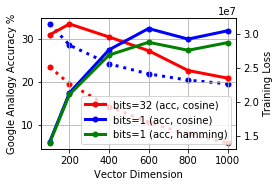

In [7]:
fig, ax = plt.subplots()
fig.set_figheight(2.7)
fig.set_figwidth(4)

ax_size_accuracy = ax
ax_size_loss = ax.twinx()
ax_size_accuracy.set_zorder(ax_size_loss.get_zorder() + 1)
ax_size_accuracy.patch.set_visible(False)
ax_size_accuracy.plot(
    size,
    [get_accuracy(params, bitwise=False) for params in product((0,), size, (10,))],
    c='r', marker='.', label='bits=32 (acc, cosine)',
)
ax_size_loss.plot(
    size,
    [get_loss(params) for params in product((0,), size, (10,))],
    c='r', marker='.', linestyle=':',
)
ax_size_accuracy.plot(
    size,
    [get_accuracy(params, bitwise=False) for params in product((1,), size, (10,))],
    c='b', marker='.', label='bits=1 (acc, cosine)',
)
ax_size_loss.plot(
    size,
    [get_loss(params) for params in product((1,), size, (10,))],
    c='b', marker='.', linestyle=':',
)
ax_size_accuracy.plot(
    size,
    [get_accuracy(params, bitwise=True) for params in product((1,), size, (10,))],
    c='g', marker='.', label='bits=1 (acc, hamming)',
)
ax_size_accuracy.set_xlabel('Vector Dimension')
ax_size_accuracy.set_ylabel('Google Analogy Accuracy %')
ax_size_loss.set_ylabel('Training Loss')
ax_size_accuracy.grid(True)
ax_size_accuracy.legend(loc='best')

plt.tight_layout()
plt.savefig('figures/accuracy-size.pdf')
plt.savefig('figures/accuracy-size.png', dpi=300)
plt.show()

Plot speed of `compute_accuracy` and `compute_accuracy_bitwise`, excluding time required to load word vectors:

In [8]:
def get_duration(params, bitwise=False):
    filename = 'analogy{}/{}b_{}d_vectors_e{}'.format('_bitwise' if bitwise else '', *params)
    with open(filename, 'rt') as f:
        line = f.readlines()[-1]
    match = re.match(r'^Computed accuracy in (?P<duration>[0-9.]*) seconds$', line)
    assert match, 'Failed to find time measurements in {}'.format(filename)
    duration = float(match.groups('duration')[0])
    return duration

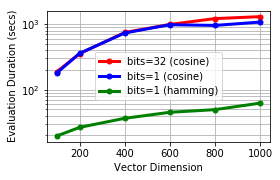

In [9]:
fig, ax = plt.subplots()
fig.set_figheight(2.6)
fig.set_figwidth(4)

ax.plot(
    size,
    [get_duration(params, bitwise=False) for params in product((0,), size, (10,))],
    c='r', marker='.', label='bits=32 (cosine)',
)
ax.plot(
    size,
    [get_duration(params, bitwise=False) for params in product((1,), size, (10,))],
    c='b', marker='.', label='bits=1 (cosine)',
)
ax.plot(
    size,
    [get_duration(params, bitwise=True) for params in product((1,), size, (10,))],
    c='g', marker='.', label='bits=1 (hamming)',
)
ax.set_xlabel('Vector Dimension')
ax.set_ylabel('Evaluation Duration (secs)')
ax.set_yscale('log')
ax.grid(True, which='major')
ax.grid(True, which='minor')
ax.legend(loc='center')

plt.tight_layout()
plt.savefig('figures/speed-size.pdf')
plt.savefig('figures/speed-size.png', dpi=300)
plt.show()